In [5]:
!pip install tensorflow[and-cuda] matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 285.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 314.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 249.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [6]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.python.platform import build_info as tf_build_info
print("CUDA version:", tf_build_info.cuda_version_number)
print("CuDNN version:", tf_build_info.cudnn_version_number)


TensorFlow version: 2.18.0


AttributeError: module 'tensorflow.python.platform.build_info' has no attribute 'cuda_version_number'

In [7]:

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt


## Set random seed for reproducibility

In [8]:

# Set random seed for reproducibility
tf.random.set_seed(42)


## Load and preprocess MNIST data

In [9]:

# Load and preprocess MNIST data
def load_and_preprocess_data():
    # Load MNIST dataset
    (x_train, _), (x_test, _) = mnist.load_data()
    
    # Normalize pixel values to [0, 1]
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    
    # Flatten the images
    x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
    x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
    
    return x_train, x_test

x_train, x_test = load_and_preprocess_data()
print("Training data shape:", x_train.shape)
print("Test data shape:", x_test.shape)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training data shape: (60000, 784)
Test data shape: (10000, 784)


## Build the autoencoder model

In [10]:

# Build the autoencoder model
def create_autoencoder(input_dim=784, encoding_dim=32):
    # Encoder
    encoder_input = layers.Input(shape=(input_dim,))
    x = layers.Dense(1000, activation='relu')(encoder_input)
    x = layers.Dense(500, activation='relu')(x)
    x = layers.Dense(250, activation='relu')(x)
    encoder_output = layers.Dense(encoding_dim, activation='relu', name='encoder')(x)
    
    # Decoder
    decoder_input = layers.Dense(250, activation='relu')(encoder_output)
    x = layers.Dense(500, activation='relu')(decoder_input)
    x = layers.Dense(1000, activation='relu')(x)
    decoder_output = layers.Dense(input_dim, activation='sigmoid')(x)
    
    # Create full autoencoder model
    autoencoder = models.Model(encoder_input, decoder_output)
    encoder = models.Model(encoder_input, encoder_output)
    
    return autoencoder, encoder

autoencoder, encoder = create_autoencoder()
autoencoder.summary()

I0000 00:00:1730477689.841874     174 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43598 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:d2:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1000)           │       785,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 500)            │       500,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 250)            │       125,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Dense)                 │ (None, 32)             │         8,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 250)            │         8,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 500)            │       125,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1000)           │       501,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 784)            │       784,784 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,838,316 (10.83 MB)

 Trainable params: 2,838,316 (10.83 MB)

 Non-trainable params: 0 (0.00 B)

## Train the autoencoder

In [11]:

# Train the autoencoder
def train_autoencoder(autoencoder, x_train, x_test):
    # Compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    # Train the model
    history = autoencoder.fit(
        x_train, x_train,  # Input and target are the same for autoencoder
        epochs=20,  # Increased epochs for better convergence
        batch_size=128,
        shuffle=True,
        validation_data=(x_test, x_test),
        verbose=1  # Show training progress
    )
    
    return history

history = train_autoencoder(autoencoder, x_train, x_test)

Epoch 1/20


I0000 00:00:1730477700.192141     525 service.cc:148] XLA service 0x7bf7bc00ecb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730477700.192168     525 service.cc:156]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2024-11-01 16:15:00.233704: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1730477700.463770     525 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-01 16:15:12.848406: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_292', 64 bytes spill stores, 64 bytes spill loads

2024-11-01 16:15:12.951749: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_313', 64 bytes spill stores, 

 68/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3710

I0000 00:00:1730477729.820548     525 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


459/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2307

2024-11-01 16:15:39.656822: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_313', 64 bytes spill stores, 64 bytes spill loads

2024-11-01 16:15:39.958338: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_292', 236 bytes spill stores, 236 bytes spill loads

2024-11-01 16:15:40.152379: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_292', 80 bytes spill stores, 80 bytes spill loads

2024-11-01 16:15:40.363567: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_698', 8 bytes spill stores, 8 bytes spill loads

2024-11-01 16:15:41.251162: I external/local_xla/xla/stream_exec

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.2293

2024-11-01 16:16:10.260355: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_32', 220 bytes spill stores, 228 bytes spill loads

2024-11-01 16:16:10.695456: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_74', 220 bytes spill stores, 228 bytes spill loads

2024-11-01 16:16:10.801501: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_60', 180 bytes spill stores, 180 bytes spill loads

2024-11-01 16:16:10.831566: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_67', 208 bytes spill stores, 208 bytes spill loads



469/469 ━━━━━━━━━━━━━━━━━━━━ 73s 90ms/step - loss: 0.2292 - val_loss: 0.1148
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1102 - val_loss: 0.1002
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0973 - val_loss: 0.0914
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0915 - val_loss: 0.0886
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0882 - val_loss: 0.0856
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0859 - val_loss: 0.0852
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0842 - val_loss: 0.0836
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0832 - val_loss: 0.0839
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0822 - val_loss: 0.0827
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0816 - val_loss: 0.0822
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0811 - val_loss: 0.0824
Epoch 12/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 

## Visualize results

2024-11-01 16:16:52.755045: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33', 64 bytes spill stores, 64 bytes spill loads

2024-11-01 16:16:55.049115: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_26', 408 bytes spill stores, 444 bytes spill loads

2024-11-01 16:16:55.050351: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33', 116 bytes spill stores, 116 bytes spill loads

2024-11-01 16:16:55.172990: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_26', 236 bytes spill stores, 236 bytes spill loads

2024-11-01 16:16:55.616158: I external/local_xla/xla/stream_ex

313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step


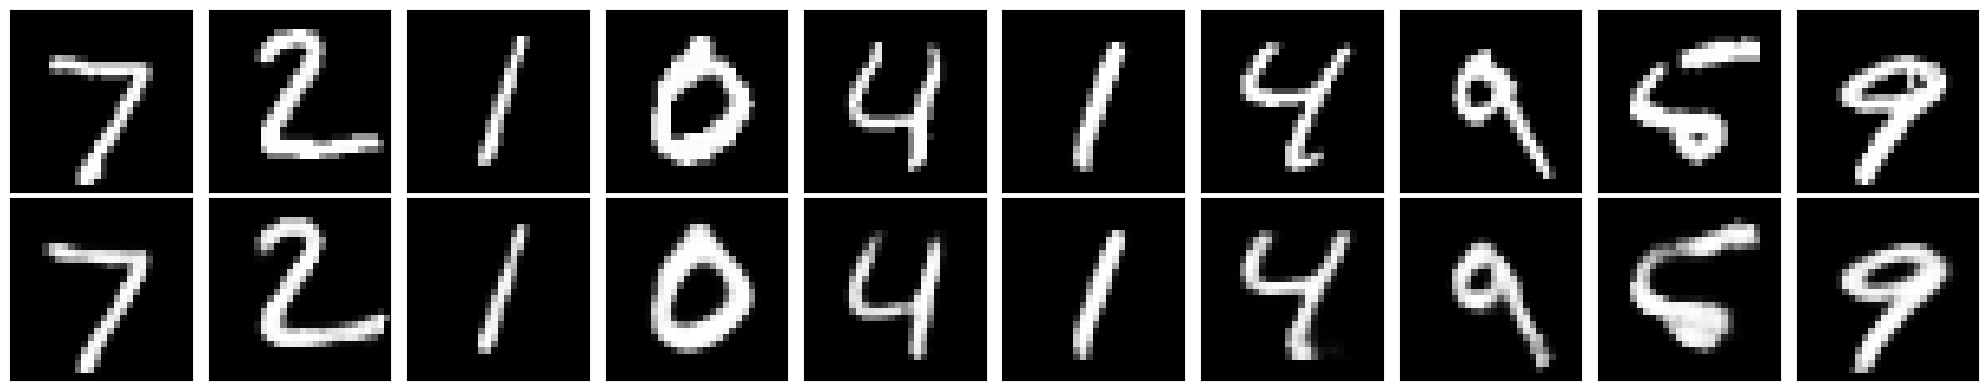

In [12]:

# Visualize results
def visualize_reconstructions(autoencoder, x_test):
    # Predict reconstructions
    decoded_imgs = autoencoder.predict(x_test)
    
    # Number of images to display
    n = 10
    plt.figure(figsize=(20, 4))
    
    for i in range(n):
        # Original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # Reconstructed images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.tight_layout()
    plt.show()

visualize_reconstructions(autoencoder, x_test)